### importing and sanity checks

In [1]:
import torch
import torchvision
import torchmetrics
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
#!{sys.executable} -m pip install opencv-python matplotlib
#!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

#!mkdir images
#!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
#!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
torch.use_deterministic_algorithms(False)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

import numpy as np
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import matplotlib.pyplot as plt

import urllib.request
import os
from tqdm import tqdm

PyTorch version: 1.11.0+cu115
Torchvision version: 0.12.0+cu115
CUDA is available: True
env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [3]:
def show_mask(mask, ax, random_color=False, color_red=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    elif color_red:
        color = np.array([255/255, 0/255, 0/255, 0.6])
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=10):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=0.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=0.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


### Download model checkpoint
Note to self: checkpoint is 2.39GB do not start download with bad bandwith

In [2]:
url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filepath = "sam_vit_h_4b8939.pth"

if not os.path.exists(filepath):
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filepath, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

NameError: name 'os' is not defined

In [5]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Tree DATA

In [1]:
#directory_path = "/var/home/daniel/Documents/Bachelor-project/newdata/new/citytrees_cache_no_test/patches"

#data = torch.load('patches/train_0.pt')

#print(data.items())

#print((data['target'].shape))
#print((data['instance_area']).shape)
#print((data['target_mask']).shape)

In [8]:
print((data['target'].shape))

torch.Size([300, 300])


In [9]:
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

def data_transform(data):
    data = data - np.min(data)
    data = np.round(data * 255/np.max(data))
    data = data.astype(np.uint8)
    return np.array(data)

directory = "patches"

def train_patches(directory):
    transformed_data_list = []
    targets = []
    non_targets = []
    for filename in os.listdir(directory):
        if filename.startswith("train_") and filename.endswith(".pt"):
            file_path = os.path.join(directory, filename)
            try:
                data0 = torch.load(file_path)
                data1 = data0['aerial_20'].numpy()
                data1 = data1.transpose()
                transformed_data = data_transform(data1)
                transformed_data_list.append(transformed_data)
                
                target1 = data0['target'].numpy()
                targets.append(target1)
                
                nontargets1 = data0['target_mask'].numpy() - target1
                non_targets.append(nontargets1)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    return transformed_data_list, targets, non_targets

data, targets, non_targets = train_patches(directory)
print(len(data), len(targets), len(non_targets))

3566 3566 3566


In [10]:
def find_pixel_target(target):
    my_array = target
    itemindex = np.where(my_array == 1)
    row_indices, col_indices = itemindex
    return row_indices, col_indices

In [11]:
#xs, ys = find_pixel_target(targets[0])

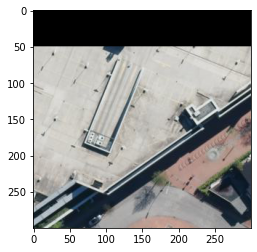

In [12]:
plt.imshow(data[0])

In [13]:
def plot_image_with_segmentation(image, segmentation, ax=None):

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


In [14]:
non_targets[0]

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [53]:
def get_points_a_labels(targets, non_targets, num_to_remove=0):
    positive_input_points = []
    positive_input_label = []
    
    negative_input_points = []
    negative_input_label = []
    
    for i in range(len(targets)):
        pos_xs, pos_ys = find_pixel_target(targets)
        for j in range(len(pos_xs)):
            positive_input_points.append((pos_xs[j],pos_ys[j]))
            positive_input_label.append(1)
        
        neg_xs, neg_ys = find_pixel_target(non_targets)
        for j in range(len(neg_xs)):
            negative_input_points.append((neg_xs[j],neg_ys[j]))
            negative_input_label.append(0)
    
    pos_labels = np.array(positive_input_label)
    pos_points = np.array(positive_input_points)
    neg_labels = np.array(negative_input_label)
    neg_points = np.array(negative_input_points)
    
    if not(num_to_remove== 0):
        num_to_remove = int(len(neg_points) * num_to_remove)
        indices = list(range(len(neg_points)))

        np.random.shuffle(indices)

        ne_po = [neg_points[i] for i in indices]

        remaining_neg_labels = neg_labels[num_to_remove:]
        remaining_neg_points = ne_po[num_to_remove:]
            
        return np.concatenate((pos_labels, remaining_neg_labels)), np.concatenate((pos_points, remaining_neg_points))
    
    return np.concatenate((pos_labels, neg_labels)), np.concatenate((pos_points, neg_points))

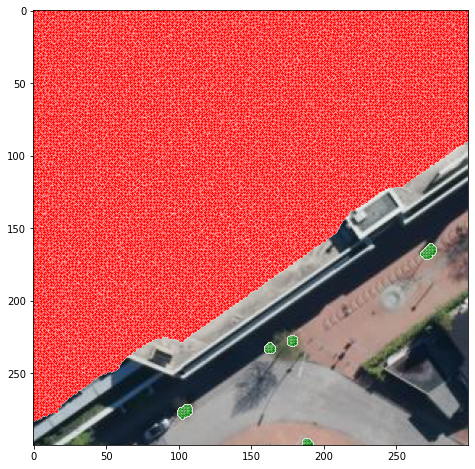

In [62]:
example_img = data[0]
input_label, input_points = get_points_a_labels(targets[0], non_targets[0], num_to_remove=0.99)

plt.figure(figsize=(8,8))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca())
plt.show() 

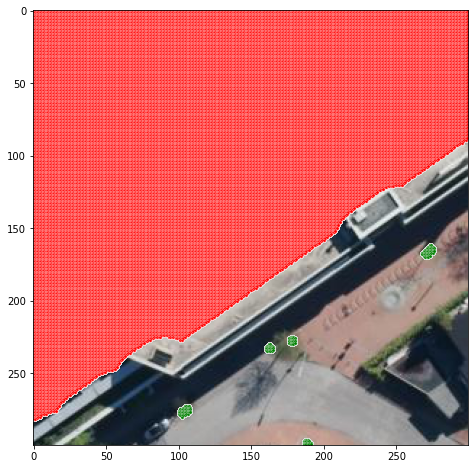

In [16]:
example_img = data[0]
input_label, input_points = get_points_a_labels(targets[0], non_targets[0])

plt.figure(figsize=(8,8))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca())
plt.show() 

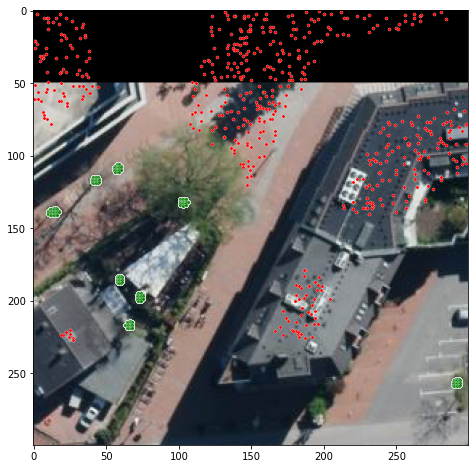

In [57]:
example_img = data[1]
input_label, input_points = get_points_a_labels(targets[1], non_targets[1], num_to_remove=0.9999)

plt.figure(figsize=(8,8))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca())
plt.show() 

In [63]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

RuntimeError: CUDA out of memory. Tried to allocate 1455.35 GiB (GPU 0; 8.00 GiB total capacity; 4.14 GiB already allocated; 856.00 MiB free; 4.83 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img)
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() #the "score" is an estimation of the mask quality

In [ ]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=inp_pointt,
    point_labels=inp_labell,
    multimask_output=True,
)

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img)
    show_mask(mask, plt.gca())
    show_points(inp_pointt, inp_labell, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() #the "score" is an estimation of the mask quality

In [ ]:
from scipy.ndimage import label

def extract_bboxes(segmentation_mask):
    labeled_mask, num_labels = label(segmentation_mask)

    bounding_boxes = []
    for label_id in range(1, num_labels + 1):
        label_indices = np.where(labeled_mask == label_id)

        x_min = np.min(label_indices[1])
        y_min = np.min(label_indices[0])
        x_max = np.max(label_indices[1])
        y_max = np.max(label_indices[0])

        bounding_boxes.append([x_min, y_min, x_max, y_max])

    return bounding_boxes

extract_bboxes(masks[0])

In [ ]:
example_img, example_mask = data[0], mask

plt.figure(figsize=(10,10))
plt.imshow(example_img)
#show_mask(example_mask, plt.gca())
show_box(extract_bboxes(example_mask)[-1], plt.gca())
show_box(extract_bboxes(example_mask)[-2], plt.gca())
plt.axis('on')
plt.show()

In [ ]:
#try:
#    from ultralytics import YOLO
#except:
#    !pip install ultralytics
#    from ultralytics import YOLO

#model = YOLO('yolov8n.pt')  # load a pretrained model, which is also recommended for further training

# Train the model, data required to be on the right format
# model.train(data='/custom.yaml', epochs=100, imgsz=256)

In [ ]:
#small test
#prediction = model.predict(x_train[0])
#prediction[0].boxes.xyxy
